توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
# download data
# %%capture
import os

if len(os.listdir()) < 3:
  !wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
  !wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
  !unzip ADEChallengeData2016.zip
  !unzip release_test.zip
!pip install mmengine

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split
from random import randint, uniform, choice, normalvariate

from random import randint
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F


## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
توضیحات :
در این قسمت با توجه به خواسته مسئله توابع پیاده سازی می شوند. بدین جهت از کتابخانه open CV کمک گرفته و تغییرات را اعمال می کنیم.
هم چنین خواسته مسئله جهت عدم ایجاد ناحیه مشکی در تصویر هم در نظر گرفته می شود. بدین گونه که دو تصویر یکی کراپ شده و دیگری تصویر اصلی ایجاد شده و ناحیه مشکی ایجاد نمی شود.
تمام توابع تغییرات را به صورت رندوم اعمال می کنند.
نکته حائز اهمیت در تابع scaling  فاکتور بزرگنمایی و کوچک نمایی است.
در صورت f>1 تصویر  به حالت زوم شده و ریسایز به 224 در می آید.
در صورت f<1 نیز تصویر ریسایز شده و درون یابی می شود.
<br>

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
    نکته : در نوشتن کدهای سوال 3 از راهنمایی های آقای رمضانی نیز استفاده شده است.

<br>


In [ ]:
# function 1
def displacement(img):
  # Get image dimensions
  (height, width) = img.shape[:2]
  random_choice = np.random.choice([-1, 1],size=2)
  dx , dy= np.random.randint(25,50,size= 2)
  dx *= random_choice[0]
  dy *= random_choice[1]
  M = np.float32([[1, 0, dx], [0, 1, dy]])
  displaced_img = cv2.warpAffine(img, M, (width, height),borderMode=cv2.BORDER_REPLICATE)
  img = cv2.resize(displaced_img, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 2
def rotation(img):
  (h, w) = img.shape[:2]
  center = (w // 2, h // 2)
  random_choice = np.random.choice([-1, 1])
  degree = np.random.randint(20,40)
  M = cv2.getRotationMatrix2D(center, random_choice*degree, 1)
  img = cv2.warpAffine(img, M, (w, h),borderMode=cv2.BORDER_REPLICATE)
  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 3
def scaling(img):
  original_height , original_width = (224,224)
  scalef = np.random.randint(0,2)
  val = np.random.randint(2,4)
  if scalef == 1 :
    original_height, original_width = img.shape[:2]
    width = original_width * val
    height = original_height * val
    new_dimensions = (width, height)
    img = cv2.resize(img, new_dimensions, interpolation = cv2.INTER_LINEAR)
    center = (width//2,height//2)
    img = img[center[0]-112 : center[0] + 112 , center[1]-112 : center[1] + 112]

  else :
    width =  original_width // val
    height = original_height // val
    new_dimensions = (width, height)
    img = cv2.resize(img, new_dimensions, interpolation = cv2.INTER_LINEAR)

  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 4
def Brightness(img):  ## for augmentation
  BorD = random.randn(-1,1)
  adjusted = cv2.convertScaleAbs(img, beta= BorD * 120)
  img = cv2.resize(adjusted, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 5
def bluring(img):# for augmentation
  image = cv2.blur(img, (10,20))
  img = cv2.resize(image, (224,224), interpolation = cv2.INTER_LINEAR)
  return img

# function 6
def gaussian_noise(img):#for augmentation
  # Generate a matrix of random values with a Gaussian distribution
  mean = 100
  stddev = 150
  noise = np.zeros(img.shape, np.uint8)
  cv2.randn(noise, mean, stddev)
  noisy_img = cv2.add(img, noise)
  img = cv2.resize(noisy_img, (224,224), interpolation = cv2.INTER_LINEAR)
  return img


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
توضیحات :
در این قسمت جهت ایجاد دیتاست شخصی سازی شده ابتدا با توجه به split موردنظر کلاس دیتاست انتخاب شده و مسیر آن مشخص می شود. سپس دو تصویر یکی اصلی و دیگری تغییر یافته به تصادف از 3 تابع 1-3 تولید می شود.
تولید تصویر تغییر یافته بدین صورت است که ابتدا به صورت رندم تعداد 1 یا  2( یا 3)  تغییر انتخاب می شود. سپس باز به صورت رندم با توجه به تعداد تغییرات از 3 تابع مشخص شده توابع اعمالی تغییر انتخاب می شود.

با توجه به سخت بودن کار با لیبل multihot به جای استفاده از 3 کلاس خروجی ، 8 کلاس خروجی تولید می شود.
بدین صورت که با توجه به لیبل multi hot تولید شده ، از 1 تا 7 ( باینری 3 تایی ) یکی از 8 کلاس خروجی یک می شود.
<br>

In [ ]:
def vectoClass(vec):
    output = 0
    for i,digit in enumerate(vec) :
      output += digit * (2**i)
    return output

class CustomDataset(Dataset):
    def __init__(self, root, split='training', transform=None):
        self.root = root
        self.transform = transform
        self.data = []
        self.split = split
        path = os.path.join(self.root,self.split)

        for _,_,fnames in os.walk(path):
            for fname in fnames :
                froot = os.path.join(path,fname)
                self.data.append(froot)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img_orgin = IM(img_path)
        img_resized = cv2.resize(img_orgin, (224, 224))
        functions = [displacement, rotation, scaling]
        Aug_functions = [Brightness, bluring, gaussian_noise]
        change_vec = np.zeros(3)

        rand_num = random.randint(1,3)
        # origin_change_vec = np.random.randint(2, size=3)

        img_buff = img_resized
        for i in range(rand_num) :
            func = random.sample(functions,1)[0]
            img_buff = func(img_buff)
            change_vec[functions.index(func)] = 1
        changed_img = img_buff

        if self.transform != None:
            changed_img = self.transform(changed_img)
            img_resized = self.transform(img_resized)

        img_resized = (torch.Tensor(img_resized).permute(2, 0, 1)).numpy()
        changed_img = (torch.Tensor(changed_img).permute(2, 0, 1)).numpy()
        return img_resized, changed_img, torch.from_numpy(change_vec), vectoClass(change_vec)

    def __len__(self):
        return len(self.data)



<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
توضیحات :
خواندن و تولید دیتای train , val , test از دیتاست گفته شده

<br>

In [ ]:
dataset_train = CustomDataset(root='./ADEChallengeData2016/images/',split='training')
dataset_test = CustomDataset(root='./ADEChallengeData2016/images/',split='validation')
dataset_val = CustomDataset(root='./release_test/',split='testing')

train_loader = DataLoader(dataset=dataset_train,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=dataset_test,batch_size=32,shuffle=False)
val_loader = DataLoader(dataset=dataset_val,batch_size=32,shuffle=True)


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
توضیحات :
رسم 8 تصویر train و 8 تصویر داده test
سطر اول تصویر اصلی
سطر دوم تصویر تغیر یافته
نکته : label تولید شده به صورت دسیمال بالای تصاویر تغییر یافته نوشته شده است.
<br>

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


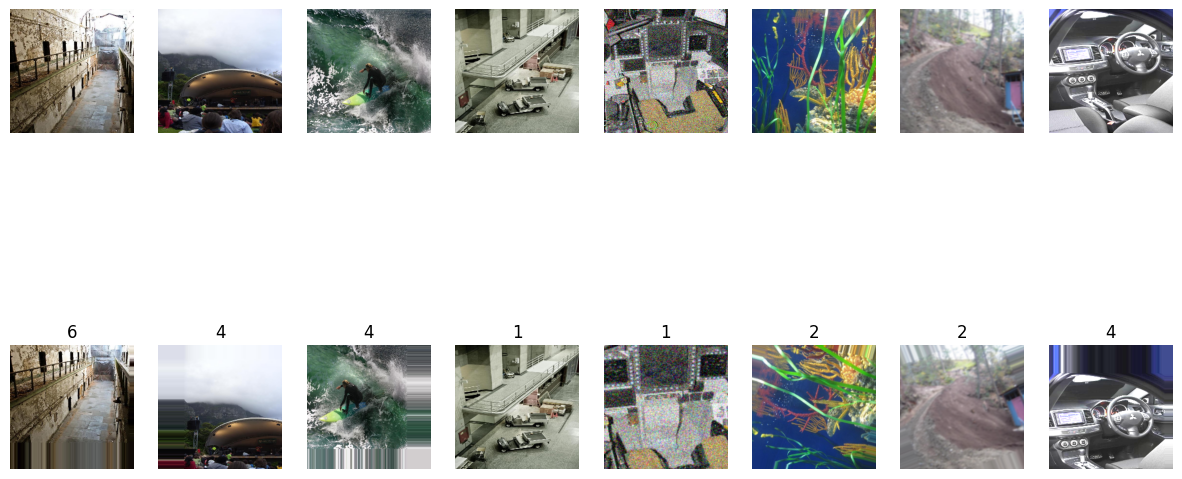

************************************


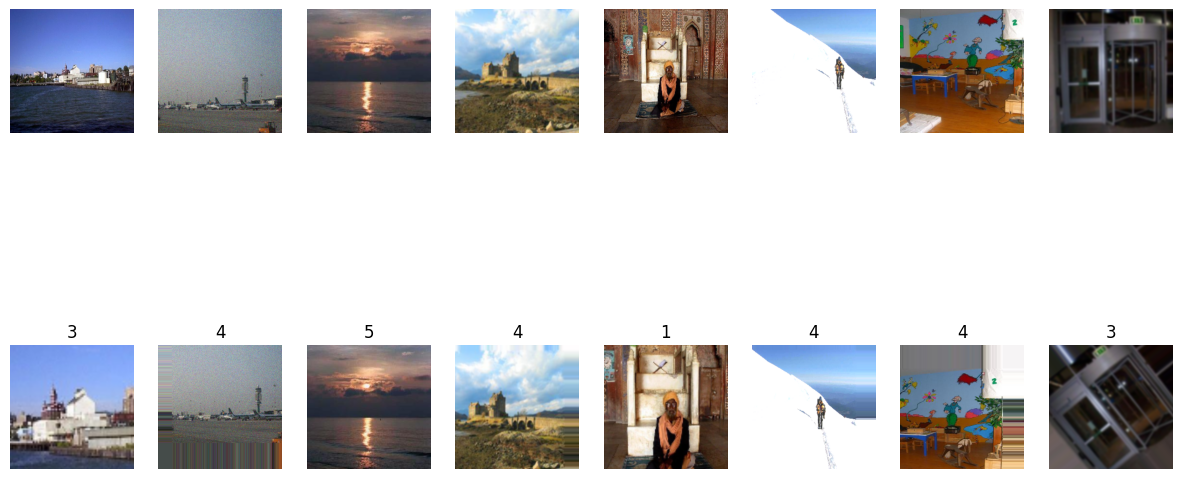

In [ ]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
selected_indices = random.sample(range(len(dataset_val)), 8)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(selected_indices):
    img_resized_original, img_resized_changed, _, labels, decimal_label = dataset_val[idx]
    print(img_resized_original.shape)
    plt.subplot(2, 8, i + 1)
    plt.imshow(img_resized_original)
    plt.axis('off')

    plt.subplot(2, 8, i + 9)
    plt.imshow(img_resized_changed)
    plt.title(f'{decimal_label}')
    plt.axis('off')

plt.show()
print('************************************')
selected_indices = random.sample(range(len(dataset_test)), 8)
plt.figure(figsize=(15, 8))
for i, idx in enumerate(selected_indices):
    img_resized_original, img_resized_changed, _, labels, decimal_label = dataset_test[idx]

    plt.subplot(2, 8, i + 1)
    plt.imshow(img_resized_original)
    plt.axis('off')

    plt.subplot(2, 8, i + 9)
    plt.imshow(img_resized_changed)
    plt.title(f'{decimal_label}')
    plt.axis('off')

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

> Indented block



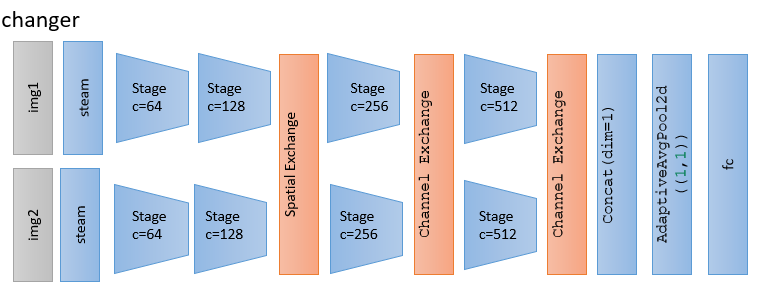

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


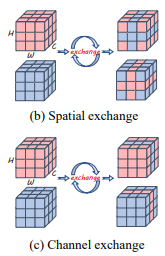

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

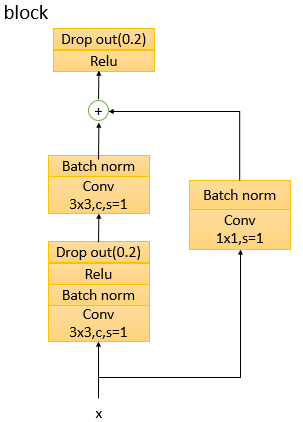

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
سوال تئوری (1.
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)

 channel out size ( conv(1*1))  = out_channels تعداد کانال خروجی block هر چه باشد، این سایز همان مقدار را می گیرد.
  padding(conv) :    
  سایز padding جهت یکی کردن سایز  out  , out1 مقدار 1 انتخاب می شود.

2.  دلیل استفاده از کانولوشن 1در1 چیست؟
کاهش بعد ( dimension reduction)
برای مثال با استفاده از conv 32.1.1 : بر روی تصویر 192.n.n سایز نهایی 32 تایی خواهد بود.
<br>





In [ ]:
class block(nn.Module):
  def __init__(self, in_channelSize, out_channelSize, stride=1):
    super(block,self).__init__()

    self.stride = stride
    self.skip = nn.Sequential(
        nn.Conv2d(in_channels=in_channelSize, out_channels=out_channelSize, kernel_size=1, stride=self.stride, bias=False),
        nn.BatchNorm2d(out_channelSize)
    )
    self.block = nn.Sequential(
        nn.Conv2d(in_channels=in_channelSize, out_channels=out_channelSize, kernel_size=3, padding=1, stride=self.stride, bias=False),
        nn.BatchNorm2d(out_channelSize),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        nn.Conv2d(in_channels=out_channelSize, out_channels=out_channelSize, kernel_size=3, padding=1, stride=self.stride, bias=False),
        nn.BatchNorm2d(out_channelSize),
    )
    self.outblock = nn.Sequential(
        nn.ReLU(),
        nn.Dropout(0.2),
    )

  def forward(self,x):
    out = self.block(x)
    out2 = self.skip(x)
    out += out2
    out = self.outblock(out)
    return out

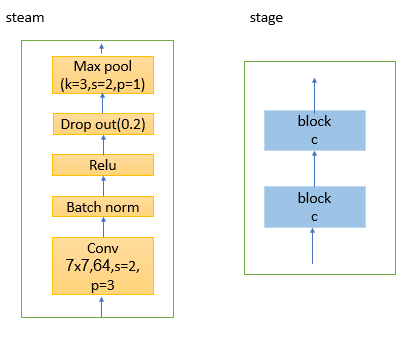

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
توضیحات :     
در این مرحله یک کلاس برای بلوک Steam نوشته می شود.
تصویر ورودی این بلوک RGB بوده و دارای سایز کانال 3 است .
سایز کانال خروجی بنا به سازگاری با ورودی stage ، 64 انتخاب می شود.

<br>

In [ ]:
class Steam(nn.Module):
    def __init__(self, in_channels):
        super(Steam, self).__init__()
        self.steam = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def forward(self, x):
        return self.steam(x)

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
توضحیات :     
در نهایت با استفاده از کلاس های block و Steam مدل خواسته شده طبق تصویر پیاده سازی می شود.
نکته حائز اهمیت سایز کانال ورودی و خروجی stage هاست. به طوری که در نهایت به سایز 512 برسیم.
به همین جهت ، سایز 64 در stage1 در ورودی و خروجی تکرار می شود.

<br>

In [ ]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.stage1= self._make_stage(block,64,64)
    self.stage2= self._make_stage(block,64,128)
    self.stage3= self._make_stage(block,128,256)
    self.stage4= self._make_stage(block,256,512)
    self.steam = Steam(3)
    self.spatialEx = SpatialExchange()
    self.channelEx = ChannelExchange()

    self.adptive_avePool = nn.AdaptiveAvgPool2d((1,1))

    self.fc = nn.Sequential(
      nn.Linear(1024, 512),
      nn.ReLU(inplace = True),
      nn.Linear(512,8),
      nn.Softmax(dim =1)
    )

  def _make_stage(self, block, in_channels, out_channels, stride=1):
        layers = [block(in_channels, in_channels, stride)]
        layers.append(block(in_channels, out_channels , stride))
        return nn.Sequential(*layers)

  def forward(self,x1,x2):
    x1 , x2 = self.steam(x1) , self.steam(x2)
    x1 , x2 = self.stage1(x1) , self.stage1(x2)
    x1 , x2 = self.stage2(x1) , self.stage2(x2)
    x1 , x2 = self.spatialEx(x1 , x2)
    x1 , x2 = self.stage3(x1) , self.stage3(x2)
    x1 , x2 = self.channelEx(x1 , x2)
    x1 , x2 = self.stage4(x1) , self.stage4(x2)
    x1 , x2 = self.channelEx(x1 , x2)
    out = torch.cat((x1,x2),dim=1)
    out = self.adptive_avePool(out)
    out = out.view(out.size(0), -1)
    output = self.fc(out)

    return output

<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
در این مرحله مدل فراخوانی شده و تابع loss انتخاب می شود.
تابع Loss با توجه به خروجی one hot به صورت BCE یعنی باینری کراس آنتروپی انتخاب می شود.
( توابع CE , BCElogitloss هم تست شده اما نتیجه بهتری گرفته نشد. )
<br>

In [ ]:
## To Do
import torch.nn.init as init

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        # Use Xavier/Glorot initialization for Conv2d and Linear layers
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

model = changer(block, SpatialExchange, ChannelExchange).to(device)

# Apply the initialization function to all model parameters
model.apply(initialize_weights)


criterion = nn.BCELoss()  # Use Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
PATH = "model.pth"


cuda


##Train & validation


In [ ]:
import gc
gc.collect()


In [ ]:
from tqdm import tqdm

def decimal_to_one_hot(dec_vec, num_classes=8):
    one_hot = torch.zeros((len(dec_vec),num_classes)).to(device)
    for i , elem in enumerate(dec_vec) :
      one_hot[i][int(elem)] = 1
    return one_hot

Loss_train=[]
loss_valid=[]
acc_train=[]
acc_valid=[]


num_epochs = 10


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    for i,(origin_img, changed_img, label_vecs , labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training')):
        origin_img, changed_img, label_vecs , labels = origin_img.to(device), changed_img.to(device), label_vecs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(origin_img,changed_img)
        loss = criterion(outputs, decimal_to_one_hot(labels))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)

    train_loss /= len(train_loader.dataset)
    Loss_train.append(train_loss)
    acc = correct_train/len(train_loader.dataset)
    acc_train.append(acc)
    print(f'Epoch: {epoch+1} \tloss_TRAIN ={train_loss:.3f},acc_train={acc:.3f}')
    # Validation
    model.eval()
    valid_loss = 0.0
    correct_valid = 0

    with torch.no_grad():
        for (origin_img, changed_img, label_vecs , labels) in tqdm(val_loader):
          origin_img, changed_img, label_vecs , labels = origin_img.to(device), changed_img.to(device), label_vecs.to(device), labels.to(device)
          outputs = model(origin_img, changed_img)
          loss = criterion(outputs, decimal_to_one_hot(labels))
          valid_loss += loss.item() * labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct_valid += (predicted == labels).sum().item()
    valid_loss /= len(val_loader.dataset)
    loss_valid.append(valid_loss)
    acc = correct_valid/len(val_loader.dataset)
    acc_valid.append(acc)
    print(f'Epoch: {epoch+1}\t loss_val= {valid_loss:.3f}, acc_val={acc:.3f}')



torch.save(model, 'model.pth')

torch.save(model.state_dict(), 'model_weights.pth')

Epoch 1/10 - Training: 100%|██████████| 632/632 [08:13<00:00,  1.28it/s]


Epoch: 1 	loss_TRAIN =0.341,acc_train=0.231


100%|██████████| 105/105 [00:43<00:00,  2.42it/s]


Epoch: 1	 loss_val= 0.337, acc_val=0.232


Epoch 2/10 - Training: 100%|██████████| 632/632 [08:14<00:00,  1.28it/s]


Epoch: 2 	loss_TRAIN =0.330,acc_train=0.266


100%|██████████| 105/105 [00:43<00:00,  2.42it/s]


Epoch: 2	 loss_val= 0.327, acc_val=0.260


Epoch 3/10 - Training: 100%|██████████| 632/632 [08:14<00:00,  1.28it/s]


Epoch: 3 	loss_TRAIN =0.329,acc_train=0.274


100%|██████████| 105/105 [00:43<00:00,  2.42it/s]


Epoch: 3	 loss_val= 0.326, acc_val=0.288


Epoch 4/10 - Training: 100%|██████████| 632/632 [08:14<00:00,  1.28it/s]


Epoch: 4 	loss_TRAIN =0.327,acc_train=0.274


100%|██████████| 105/105 [00:43<00:00,  2.39it/s]


Epoch: 4	 loss_val= 0.325, acc_val=0.292


Epoch 5/10 - Training: 100%|██████████| 632/632 [08:14<00:00,  1.28it/s]


Epoch: 5 	loss_TRAIN =0.315,acc_train=0.312


100%|██████████| 105/105 [00:43<00:00,  2.42it/s]


Epoch: 5	 loss_val= 0.332, acc_val=0.270


Epoch 6/10 - Training: 100%|██████████| 632/632 [08:14<00:00,  1.28it/s]


Epoch: 6 	loss_TRAIN =0.272,acc_train=0.384


100%|██████████| 105/105 [00:43<00:00,  2.41it/s]


Epoch: 6	 loss_val= 0.468, acc_val=0.219


Epoch 7/10 - Training: 100%|██████████| 632/632 [08:14<00:00,  1.28it/s]


Epoch: 7 	loss_TRAIN =0.246,acc_train=0.453


100%|██████████| 105/105 [00:43<00:00,  2.42it/s]


Epoch: 7	 loss_val= 0.689, acc_val=0.210


Epoch 8/10 - Training: 100%|██████████| 632/632 [08:14<00:00,  1.28it/s]


Epoch: 8 	loss_TRAIN =0.222,acc_train=0.525


100%|██████████| 105/105 [00:43<00:00,  2.41it/s]


Epoch: 8	 loss_val= 0.755, acc_val=0.227


Epoch 9/10 - Training: 100%|██████████| 632/632 [08:15<00:00,  1.28it/s]


Epoch: 9 	loss_TRAIN =0.194,acc_train=0.608


100%|██████████| 105/105 [00:43<00:00,  2.39it/s]


Epoch: 9	 loss_val= 1.122, acc_val=0.217


Epoch 10/10 - Training:  94%|█████████▎| 591/632 [07:43<00:31,  1.28it/s]

#Test


<div dir="rtl" style="text-align: justify"><font face="B Nazanin" size=4>
نتایج acc val بسیار زیاد تحت تاثیر learning rate و وزن های اولیه است.
در هر بار ران کردن نتایج متفاوت حاصل می شود.
در یک بار ران دقت val تا 60 هم می تواند بالا رود.
<br>

In [ ]:
checkpoint = torch.load(PATH)  # Replace PATH with the actual path
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Test
model.eval()
loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_original, inputs_changed, _, labels in tqdm(test_loader):
        inputs_original, inputs_changed, labels = inputs_original.to(device), inputs_changed.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs_original, inputs_changed)
        loss = criterion(outputs, decimal_to_one_hot(labels))

        # Convert probabilities to one-hot
        _, predicted = torch.max(outputs.data, 1)
        correct_valid += (predicted == labels).sum().item()
        total_test += labels.size(0)

        loss_test += loss.item()

avg_loss_test = loss_test / len(test_loader)
acc = correct_valid/len(val_loader.dataset)

print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Loss_test: {avg_loss_test:.3f}, Acc_test: {acc:.3f}')

100%|██████████| 63/63 [00:32<00:00,  1.95it/s]

Epoch [10/10], Avg Loss_test: 1.323, Acc_test: 0.669


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟